<br/>
  <FONT size ="3pt"> MODAL APM 41M01 : Problem solving en math app </FONT>   
  
---
---
<FONT size ="5pt"> TP déterministe 4 : <center><b>Autour de l'équation eikonale</b>  </center></FONT>

---
---
<br />

**<big><font color=black><span style="background-color:skyblue">Rendu attendu : Partie 1</span></font>**

Dans ce TP, on cherche à modéliser la propagation (de la lumière par exemple) dans un milieu à indice variable, c'est-à-dire que la vitesse dépend de l'endroit où l'on est.

Le but est de pouvoir calculer le plus court chemin entre un point de départ $(s_x,s_y)$ et un point d'arrivée. Pour ce faire, on calcule pout tout point $(x,y)$ le temps $\phi(x,y)$ mis pour aller de $(s_x,s_y)$ jusqu'à $(x,y)$. On peut montrer que $\phi$ vérifie l'équation eikonale

$$\|\nabla \phi \|=n(x,y), \qquad\phi(s_x,s_y) = 0.$$

Afin de résoudre cette équation, on propose de la réécrire sous la forme  d'une équation instationnaire

$$\frac{\partial \phi}{\partial t} + \|\nabla \phi \|=n(x,y), \qquad \phi(t,s_x,s_y) = 0\qquad\phi(0,x,y)=0.$$

et de chercher des solutions stationnaires (indépendantes du temps) en faisant tendre $t$ vers l'infini.

In [ ]:
# Pour gérer le mode interactif comme les clics
# !pip install ipympl

In [ ]:
 # Pour gérer le mode interactif comme les clics
# %matplotlib widget

In [ ]:
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from tqdm import tqdm # For progress bar

# Résolution de l'équation eikonale
On va dans un premier temps résoudre l'équation eikonal sur $\phi$ avec le schéma numérique de Lax-Friedrichs.
On propose de mailler le domaine $\Omega=[0,1]^2$ dans lequel l'onde se propage à l'aide d'un pas $h$ constant en $x$ et en $y$.
On prendra dans un premier temps $h=1/64$, mais on modifiera $h$ pour le réduire par la suite.
Le schéma de Lax-Friedrichs consiste à écrire (on utilisera $\phi_{ij} \approx \phi(ih,jh)$)

$$\phi_{ij}^{p+1} = \frac{\phi_{i+1,j}^{p}+\phi_{i-1,j}^{p}+\phi_{i,j+1}^{p}+\phi_{i,j-1}^{p}}{4}-\Delta t H\left(ih,jh,\frac{\phi_{i+1,j}^{p}-\phi_{i-1,j}^{p}}{2h},\frac{\phi_{i,j+1}^{p}-\phi_{i,j-1}^{p}}{2h}\right),$$

où

$$H(x,y,\phi_x,\phi_y) = \sqrt{\phi_x^2+\phi_y^2}-n(x,y).$$

1. Implémenter le schéma de Lax-Friedrichs pour résoudre l'équation eikonal. On prendra par exemple (mais vous pouvez bien sûr tester d'autres paramètres) :
    - $\Delta t=h/2$
    - $h = 1/64$
    - le temps final doit être suffisamment grand pour atteindre un régime stationnaire. On pourra par exemple utiliser un critère d'arrêt.
    - On prendra soin de maintenir la valeur $\phi^p_{i_*,j_*}=0$ au point de départ $(s_x,s_y)$ pour tout $p$. On pourra choisir $(s_x,s_y)=(i_*h,j_*h)$ sur la grille.
    - On prendra également au bord

$$\phi_{1,j}^p = \phi_{2,j}^p, \qquad \phi_{N,j}^p = \phi_{N-1,j}^p,\qquad \phi_{i,1}^p = \phi_{i,2}^p,\qquad\phi_{i,N}^p=\phi_{i,N-1}^p.$$

*Indication :* Penser à bien décomposer les différentes parties de votre algorithme pour simplifier son implémentation. Un exemple modifiable vous est proposé.

2. Tracer les lignes de niveau de $\phi$ au cours du temps dans le cas où $n(x,y) = 1$ et $(s_x,s_y)=(0.4,0.5)$.
Vérifier que les lignes de niveau sont des cercles.

3. Considérer également le cas d'un dioptre où l'indice est différent dans deux parties du domaine :

$$n(x,y) = \left\{
\begin{array}{ll}
1  &\text{ si } y \leq 0.5, \\
10 &\text{ si } y >    0.5,
\end{array}\right.$$

et avec $(s_x,s_y)=(0.5,0.1)$.

Cette expérience correspond à chercher les plus courts chemins pour rallier le point d'une plage (où l'indice est petit et donc la vitesse est grande) à n'importe quel autre point du domaine, y compris au milieu de la mer (l'indice est plus grand, donc la vitesse de déplacement est inférieure).


4. Prendre maintenant pour l'indice la fonction

$$n(x,y) = 1+\sigma\exp(-50(x-l_x)^2 - 100(y-l_y)^2),$$

avec $\sigma = 1.5$, $l_x = 0.6$ et $l_y=0.5$. Tracer les lignes de niveau de $n$, et celles de $\phi$. Vérifier que les lignes de niveau de $\phi$ sont plus resserrées là où $n$ est plus grand.

In [ ]:
def condition_bord(phi):
    """
    Impose une condition de flux nul au bord
    ----------

    Paramètres :
    -phi    : solution au pas n

    Retourne :
    -solution avec un flux nul au bord (même valeur à l'intérieur)
    """

    phi_new = phi.copy()
    phi_new[0,:] = phi_new[1,:]
    phi_new[-1,:] = phi_new[-2,:]
    phi_new[:,0] = phi_new[:,1]
    phi_new[:,-1] = phi_new[:,-2]
    return phi_new

In [ ]:
# 1.

def H(phi_x, phi_y, N):
    return np.sqrt(phi_x ** 2 + phi_y ** 2) - N

def LF_iteration(phi, dt, h, N):
    """
    Renvoie la nouvelle valeur de phi (après une itération) par le schéma de Lax-Friedrichs
    ----------

    Paramètres :
    -phi    : solution au pas n
    -dt     : pas de temps
    -h      : pas d'espace
    -N : matrice des indices n_ij

    Retourne :
    -solution au pas n+1
    """

    # X = np.arange(0, 1, h)
    d_phi_x = (phi[2:,1:-1] - phi[:-2,1:-1]) / (2*h)
    d_phi_y = (phi[1:-1,2:] - phi[1:-1,:-2]) / (2*h)
    phi_new  = phi.copy()
    phi_new[1:-1, 1:-1] = (phi[2:,1:-1]+phi[:-2,1:-1]+phi[1:-1,2:]+phi[1:-1,:-2]) / 4 - dt * H(d_phi_x, d_phi_y, N[1:-1, 1:-1])

    # phi_new[0,:] = phi_new[1,:]
    # phi_new[-1,:] = phi[-2,:]
    # phi_new[:,0] = phi[:,1]
    # phi_new[:,-1] = phi[:,-2]

    phi_new = condition_bord(phi_new)

    return phi_new

In [ ]:
def LF_eikonal(N, depart, h, dt, TOL, N_max):
    """
    Renvoie la solution de l'équation eikonal par le schéma de Lax-Friedrichs
    ----------

    Paramètres :
    -N : matrice des indices sigma_ij
    -depart : point de départ (indices i,j de la maille)
    -TOL    : tolérance pour la condition d'arrêt pour atteindre le régime stationnaire
    -N_max  : nombre maximal d'itérations

    Retourne :
    - la solution numérique
    """

    n_x = int(1 / h)
    phi = np.zeros((n_x, n_x), dtype=np.float64)
    for _ in tqdm(range(N_max)):
        phi_new = LF_iteration(phi, dt, h, N)
        phi_new[depart] = 0

        if np.linalg.norm(phi - phi_new) < TOL:
            return phi_new

        phi = phi_new

    return phi

In [ ]:
# 2.
# paramètres de simulation (à proposer)
h = 1/64
dt = h/2
n_x = int(1 / h)
print("nx =", n_x)

s = np.array([0.4, 0.5])
depart = tuple((s / h).astype(int))
print("Depart =", depart)
N = np.ones((n_x, n_x))

nx = 64
Depart = (np.int64(25), np.int64(32))


 19%|█▉        | 194/1000 [00:00<00:00, 11433.12it/s]


Text(0.5, 1.0, 'Lignes de niveau de phi')

<Figure size 500x400 with 0 Axes>

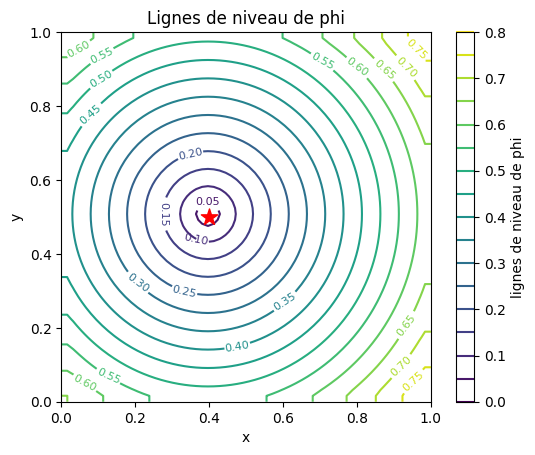

In [ ]:
# plots
def plot_contour_lines(s, phi, ax=None, add_colorbar=True):
    """Affiche les lignes de niveau de phi sur un objet Axes (ax) donné.
    Si ax n'est pas fourni, une nouvelle figure est créée."""

    if ax is None:
        fig, ax = plt.subplots()
        add_colorbar = True
    else:
        fig = ax.get_figure()

    n_x, n_y = phi.shape
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y)

    ax.scatter(s[0], s[1], color='red', marker='*', s=150, zorder=5)
    cs = ax.contour(X, Y, phi.T, levels=15, cmap='viridis')
    ax.clabel(cs, inline=True, fontsize=8)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    if add_colorbar:
        # Check if a colorbar already exists for this axes
        if not hasattr(ax, '_colorbar_added'):
            fig.colorbar(cs, ax=ax, label='lignes de niveau de phi')
            ax._colorbar_added = True  # Mark that we added a colorbar

    return ax

phi = LF_eikonal(N, depart, h, dt, TOL=1e-9, N_max=1000)
# plt.contour(phi)

plt.figure(figsize=(5, 4))
plot_contour_lines(s, phi)
plt.title('Lignes de niveau de phi')

In [ ]:
# 3.
# paramètres de simulation (à proposer)
h = 1/64
dt = h/2
n_x = int(1 / h)
print("nx =", n_x)
s = np.array([0.2, 0.5])
depart = tuple((s / h).astype(int))
print("Depart =", depart)

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)
X, Y = np.meshgrid(x, y)
x0 = 0.5
N1 = np.where(Y <= x0, 1, 3)

nx = 64
Depart = (np.int64(12), np.int64(32))


 11%|█▏        | 227/2000 [00:00<00:00, 8237.93it/s]


Text(0.5, 1.0, 'Lignes de niveau de phi')

<Figure size 500x400 with 0 Axes>

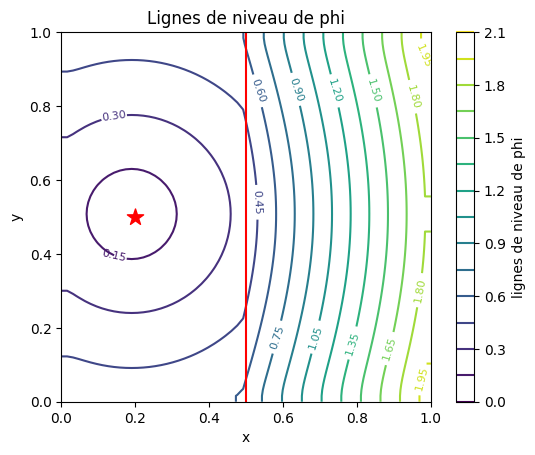

In [ ]:
# plots
phi = LF_eikonal(N1, depart, h, dt, TOL=1e-9, N_max=2000)

plt.figure(figsize=(5, 4))
plot_contour_lines(s, phi)
plt.axvline(x=x0, ymin=0, ymax=1, c='red')
plt.title('Lignes de niveau de phi')

In [ ]:
# 4.
# paramètres de simulation
h = 1/64
dt = h/2
n_x = int(1 / h)
print("nx =", n_x)
s = np.array([0.5, 0.1])
depart = tuple((s / h).astype(int))
print("Depart =", depart)

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)
X, Y = np.meshgrid(x, y)
sigma = 1.5
l_x, l_y = 0.6, 0.5
N2 = 1 + sigma * np.exp(-50*(X-l_x)**2 - 100*(Y-l_y)**2)

nx = 64
Depart = (np.int64(32), np.int64(6))


 12%|█▏        | 232/2000 [00:00<00:00, 18158.52it/s]


<a list of 6 text.Text objects>

<Figure size 500x400 with 0 Axes>

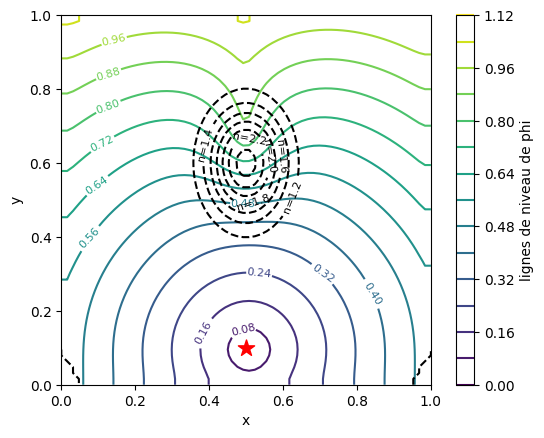

In [ ]:
# plots
phi = LF_eikonal(N2, depart, h, dt, TOL=1e-9, N_max=2000)

plt.figure(figsize=(5, 4))
plot_contour_lines(s, phi)

cs_n = plt.contour(X, Y, N2.T, colors='k', linestyles='--')
plt.clabel(cs_n, inline=True, fontsize=8, fmt="n=%.1f")

# Calcul de chemins

À partir de la solution $\phi$ de l'équation eikonal, on va maintenant chercher le trajet le plus court reliant deux points.

## Rayons lumineux

On appelle $\phi$ la solution obtenue par la méthode précédente au bout d'un temps infini (solution convergée). Comme nous l'avons dit $\phi(X)$ est le temps mis par un rayon pour atteindre $X$ en partant de la source $(s_x,s_y)$.

Les rayons lumineux se dirigent le long du gradient de $\phi$. Etant donné un point $X_0=(x_0,y_0)$, on considère l'équation différentielle

$$\frac{dX}{dt} = -\frac{\nabla \phi(X(t))}{n^2(X(t))}, \qquad X(0)=X_0. \qquad (1) $$

1. Vérifier analytiquement que

$$\frac{d}{dt}\phi(X(t)) = -1,$$

ce qui signifie que le long des trajectoires de l'équation différentielle, on remonte le temps à vitesse constante. Ainsi, la courbe partant de $X_0$ se termine au bout du temps $T=\phi(X_0)$ en $(s_x,s_y)$.

2. Implémenter une fonction qui calcul $\phi(x,y)$ en tout point $(x,y) \in \Omega$ à partir des valeurs de $\phi_{i,j} \approx \phi(ih,jh)$.
    - Pour cela, on pourra calculer les indices $(i,j)$ des quatres voisins les plus proches $x \in [ih,(i+1)h[$ et $y\in[jh,(j+1)h[$.
    - Et on calculera une interpolation de $\phi$ basée sur ces quatres valeurs voisines de $\phi_{i,j},\phi_{i+1,j},\phi_{i,j+1},\phi_{i+1,j+1}.$
    - Faites de même pour calculer le gradient $\nabla\phi$ en tout point de $\Omega$.

3. Implémenter un schéma d'Euler explicite, puis pour plus de précision un schéma de Heun (voir par exemple https://en.wikipedia.org/wiki/Heun%27s_method).

In [ ]:
# 2.
def cherche_indice(mesh_x, mesh_y, position):
    """
    Cherche les points du maillage les plus proches du point position
    ----------

    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -position       : point (vecteur 2x2) dont on cherche les points du maillage le plus proche

    Retourne :
    - indices i,j du point x[i], y[j] le plus proche
    """

    x0, y0 = position
    i = np.searchsorted(mesh_x, x0) - 1
    j = np.searchsorted(mesh_y, y0) - 1
    i = np.clip(i, 0, len(mesh_x) - 2)
    j = np.clip(j, 0, len(mesh_y) - 2)
    return i, j

def interpole_phi(mesh_x, mesh_y, position, phi):
    """
    Interpole la valeur de phi au point "position"
    ----------

    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -position       : point (vecteur 2x2) où l'on cherche à évaluer la fonction phi
    -phi            : matrices des phi_{i,j} ~ phi(x_i,y_j) aux points du maillage

    Retourne :
    - valeur approchée de phi au point "position"
    """

    x, y = position
    i, j = cherche_indice(mesh_x, mesh_y, position)

    u = (x - mesh_x[i]) / (mesh_x[i+1] - mesh_x[i])
    v = (y - mesh_y[j]) / (mesh_y[j+1] - mesh_y[j])

    # phi_x_yi = (1-u) * phi[i, j] + u * phi[i+1, j]
    # phi_x_yi_1 = (1-u) * phi[i, j+1] + u * phi[i+1, j+1]
    # phi_xy = (1-v) * phi_x_yi + v * phi_x_yi_1
    phi_xy = (1-u)*(1-v)*phi[i, j] + (1-u)*v*phi[i, j+1] + u*(1-v)*phi[i+1,j] + u*v*phi[i+1, j+1]
    return phi_xy

# def grad_phi(i, j, phi, h=1e-2):
#     """Evalue le gradient en un point de la grille"""
#     nx, ny = phi.shape
#     if 1 <= i < nx-1 and 1 <= j < ny-1:
#         grad_x = (phi[i+1, j] - phi[i-1, j]) / (2*h)
#         grad_y = (phi[i, j+1] - phi[i, j-1]) / (2*h)
#     else:
#         grad_x, grad_y = 0.0, 0.0

#     return np.array([grad_x, grad_y])

def interpole_grad_phi(mesh_x, mesh_y, position, grad_x, grad_y):
    """
    Interpole le gradient de phi au point "position"
    ----------

    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -position       : point (vecteur 2x2) où l'on cherche à évaluer la fonction phi
    -grad_x          : matrices des composantes suivant x des gradients en les points de la grille
    -grad_y          : matrices des composantes suivant y des gradients en les points de la grille

    Retourne :
    - valeur approchée du gradient de phi au point "position"
    """

    gx = interpole_phi(mesh_x, mesh_y, position, grad_x)
    gy = interpole_phi(mesh_x, mesh_y, position, grad_y)

    return np.array([gx, gy])

def grad_phi(phi, h):
    """Retourne les matrices grad_x et grad_y, matrices des composantes suivant x et y du gradient de phi sur la grille"""

    grad_x = np.zeros_like(phi)
    grad_y = np.zeros_like(phi)
    grad_x[1:-1,1:-1] = (phi[2:,1:-1] - phi[:-2,1:-1]) / (2*h)
    grad_y[1:-1,1:-1] = (phi[1:-1,2:] - phi[1:-1,:-2]) / (2*h)

    grad_x = condition_bord(grad_x)
    grad_y = condition_bord(grad_y)

    return grad_x, grad_y

In [ ]:
# proposer un test unitaire
h = 1/32
position = np.array([0.4, 0.6])
print("Position =", position)

mesh_x = np.arange(0, 1, h)
mesh_y = mesh_x
i, j = cherche_indice(mesh_x, mesh_y, position)

print(f"Indices : ({i}, {j})")
print(f"Nearest grid point : ({i*h}, {j*h})")

phi_point = interpole_phi(mesh_x, mesh_y, position, phi)
grad_x, grad_y = grad_phi(phi, h)
grad_phi_point = interpole_grad_phi(mesh_x, mesh_y, position, grad_x, grad_y)
print(f"phi{position} = {phi_point}")
print(f"grad_phi{position} = {grad_phi_point}")

Position = [0.4 0.6]
Indices : (12, 19)
Nearest grid point : (0.375, 0.59375)
phi[0.4 0.6] = 0.4036831474541237
grad_phi[0.4 0.6] = [-0.41976952  0.29073494]


In [ ]:
# paramètres de simulation
h = 1/32
dt = h/2
n_x = int(1 / h)
print("nx =", n_x)

s = np.array([0.4, 0.5])
depart = tuple((s / h).astype(int))
print("Depart =", depart)
N = np.ones((n_x, n_x))

nx = 32
Depart = (np.int64(12), np.int64(16))


100%|██████████| 300/300 [00:02<00:00, 115.61it/s]


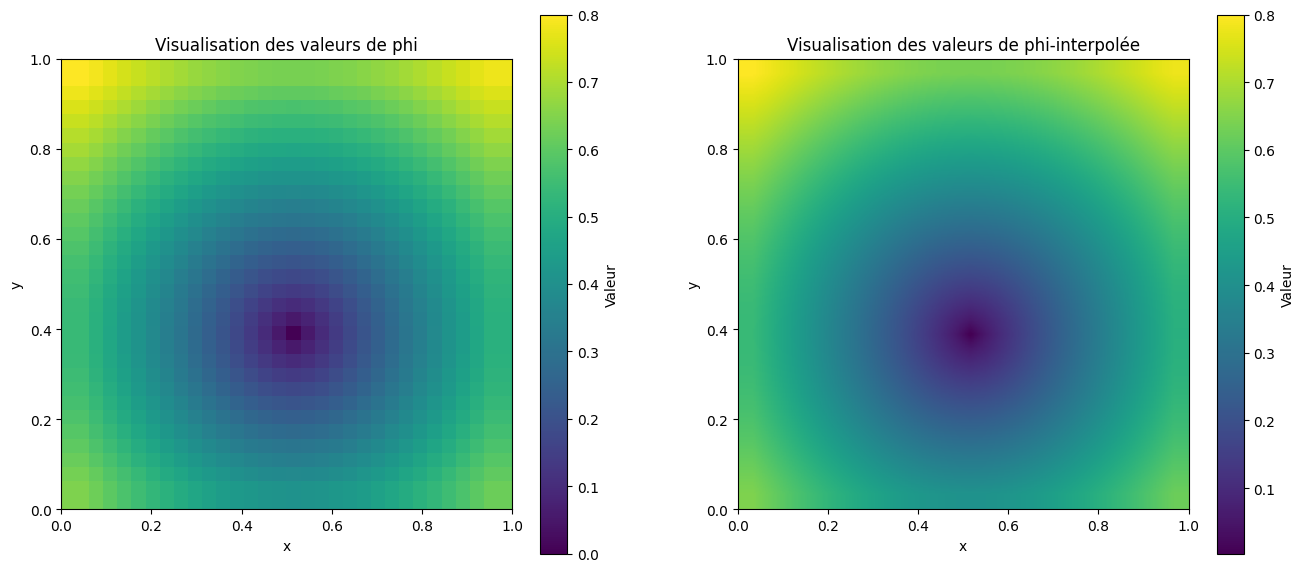

In [ ]:
# plots
def plot_matrix(ax, matrix, label):
    im = ax.imshow(matrix, origin='lower', cmap='viridis', extent=[0, 1, 0, 1], aspect='equal')
    plt.colorbar(im, ax=ax, label='Valeur')
    ax.set_title(f'Visualisation des valeurs de {label}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

phi = LF_eikonal(N, depart, h, dt, TOL=1e-9, N_max=1000)

n_plot = 300
x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)
x_plot = np.linspace(0, 1, n_plot)
y_plot = np.linspace(0, 1, n_plot)
# X, Y = np.meshgrid(x_plot, y_plot)
phi_plot = np.array([[interpole_phi(x, y, (x_, y_), phi) for y_ in y_plot] for x_ in tqdm(x_plot)])

_, ax = plt.subplots(1, 2, figsize=(16, 7))
plot_matrix(ax[0], phi, "phi")
plot_matrix(ax[1], phi_plot, "phi-interpolée")

100%|██████████| 300/300 [00:09<00:00, 32.89it/s]


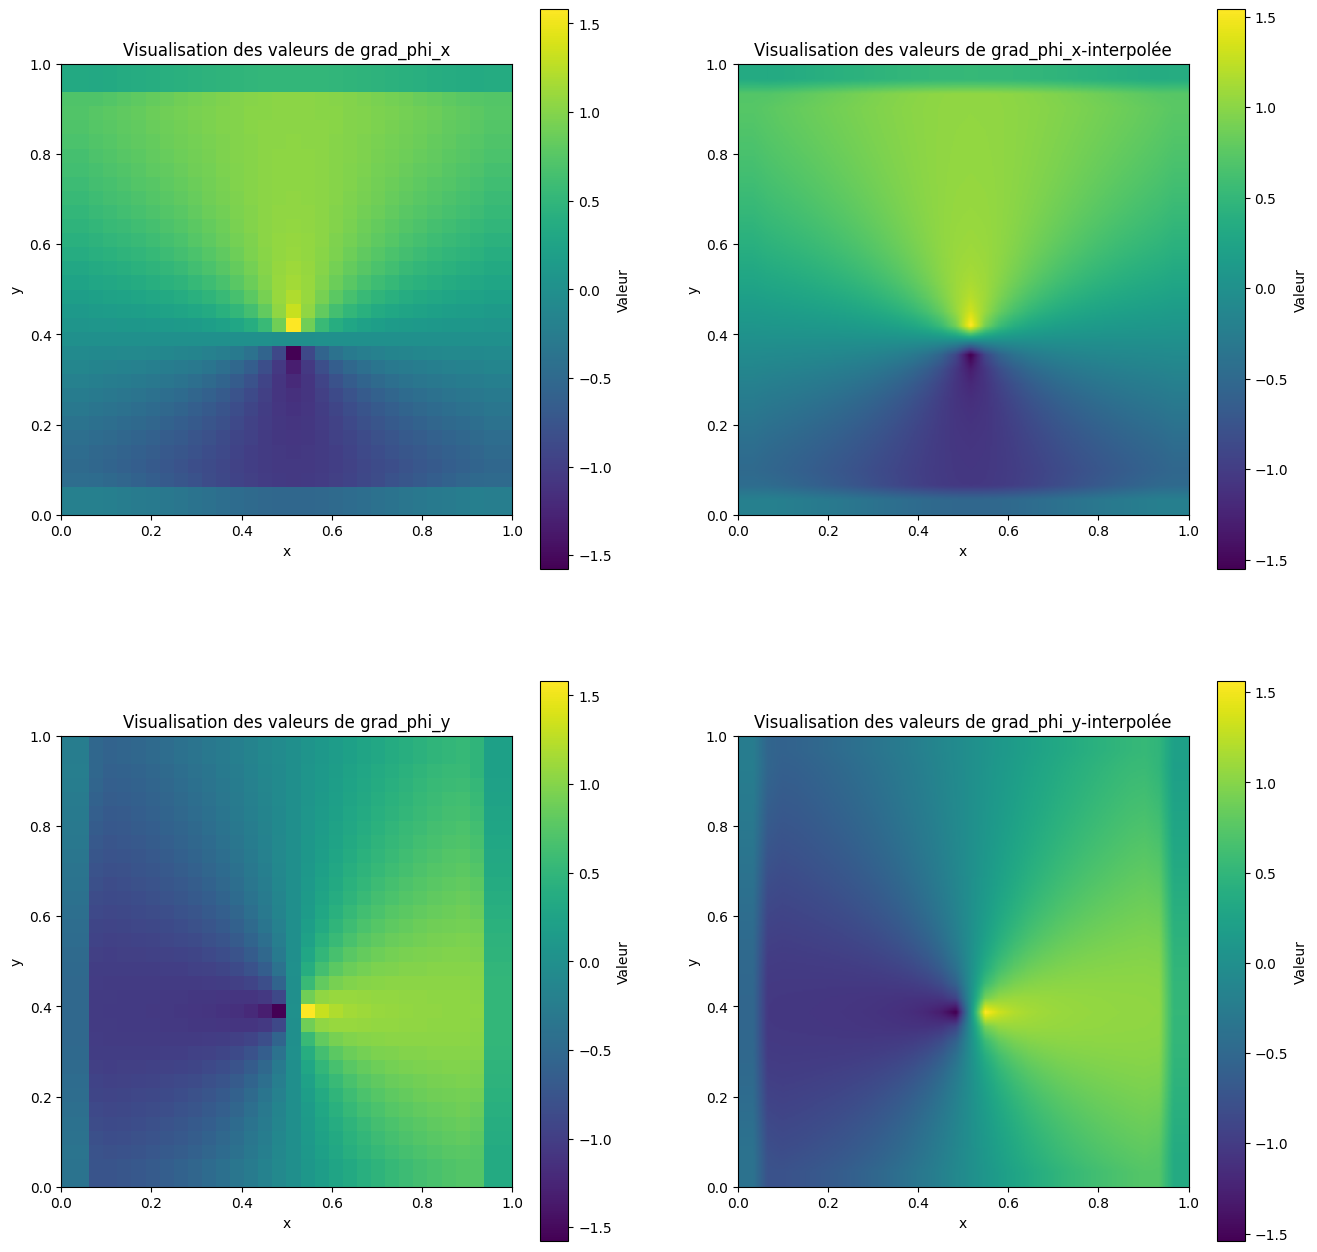

In [ ]:
# Interpolation de grad_phi
grad_x, grad_y = grad_phi(phi, h)

grad_phi_plot = np.array([[interpole_grad_phi(x, y, (x_, y_), grad_x, grad_y) for y_ in y_plot] for x_ in tqdm(x_plot)])
grad_x_plot = grad_phi_plot[:,:,0]
grad_y_plot = grad_phi_plot[:,:,1]


_, ax = plt.subplots(2, 2, figsize=(16, 16))
plot_matrix(ax[0, 0], grad_x, "grad_phi_x")
plot_matrix(ax[0, 1], grad_x_plot, "grad_phi_x-interpolée")
plot_matrix(ax[1, 0], grad_y, "grad_phi_y")
plot_matrix(ax[1, 1], grad_y_plot, "grad_phi_y-interpolée")

In [ ]:
# 3.
def solve_Euler(mesh_x, mesh_y, depart, grad_x, grad_y, indice, N_max, dt, tol=1e-6):
    """
    Résoud numériquement l'EDO avec un schéma d'Euler explicite
    ----------

    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -depart         : point de départ (ou d'arrivée)
    -grad_x          : matrices des composantes suivant x des gradients en les points de la grille
    -grad_y          : matrices des composantes suivant y des gradients en les points de la grille
    -indice         : matrice des indices aux points du maillage
    -N_max          : nombre d'itérations en temps
    -dt             : pas de l'approximation

    Retourne :
    - vecteur des positions X(t^n) à chaque pas de temps
    """


    positions = np.zeros((N_max, 2), dtype=np.float32)
    positions[0] = depart
    for i in tqdm(range(1, N_max)):
        grad = interpole_grad_phi(mesh_x, mesh_y, positions[i-1], grad_x, grad_y)
        new_point = positions[i-1] - dt * grad / (interpole_phi(mesh_x, mesh_y, positions[i-1], indice)**2)
        if np.linalg.norm(new_point - positions[i-1]) < tol:
            return positions[:i]
        positions[i] = new_point

    return positions

  9%|▉         | 94/999 [00:00<00:00, 4821.63it/s]


<Axes: title={'center': 'Chemin optimal de p=(0.1, 0.9) à s=(0.3, 0.6)'}, xlabel='x', ylabel='y'>

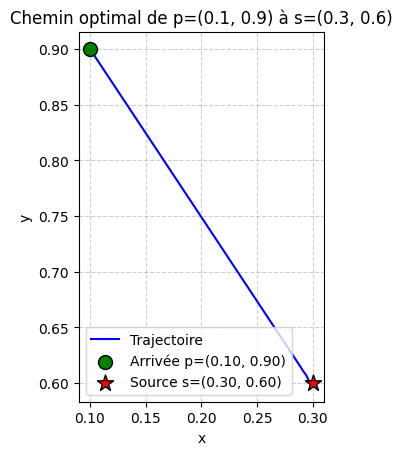

In [ ]:
# proposer un test unitaire
h = 1/128
dt = h/2
n_x = int(1 / h)
s = np.array([0.3, 0.6])
p = np.array([0.1, 0.9])
depart = tuple((s / h).astype(int))
mesh_x = np.linspace(0, 1, n_x)
mesh_y = np.linspace(0, 1, n_x)
N = np.ones((n_x, n_x))
N_max=1000

phi = LF_eikonal(N, depart, h, dt, TOL=1e-9, N_max=1000)
grad_x, grad_y = grad_phi(phi, h)
positions = solve_Euler(mesh_x, mesh_y, p, grad_x, grad_y, N, N_max, dt)

# print(positions)
def plot_path(s, p, positions, ax=None):
    """
    Visualises the calculated path from a starting point 'p' to the source 's'.
    """

    if ax is None:
        _, ax = plt.subplots()

    ax.plot(positions[:, 0], positions[:, 1], color='blue', label="Trajectoire", linewidth=1.5, zorder=3)
    ax.scatter(p[0], p[1], color='green', s=100, marker='o', label=f"Arrivée p=({p[0]:.2f}, {p[1]:.2f})", zorder=5, edgecolors='k')
    ax.scatter(s[0], s[1], color='red', s=150, marker='*', label=f"Source s=({s[0]:.2f}, {s[1]:.2f})", zorder=5, edgecolors='k')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Chemin optimal de p=({p[0]}, {p[1]}) à s=({s[0]}, {s[1]})')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    ax.set_aspect('equal')

    return ax

plot_path(s, p, positions)

In [ ]:
# paramètres de simulation
h = 1/128
dt = h/2
n_x = int(1 / h)
s = np.array([0.3, 0.6])
p = np.array([0.9, 0.1])
depart = tuple((s / h).astype(int))
mesh_x = np.linspace(0, 1, n_x)
mesh_y = np.linspace(0, 1, n_x)
N_max=1000
x0 = 0.5

#N1
x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)
X, Y = np.meshgrid(x, y)
x0 = 0.5
N1 = np.where(Y <= x0, 1, 3)

#N2
sigma = 1.5
l_x, l_y = 0.6, 0.5
N2 = 1 + sigma * np.exp(-50*(X-l_x)**2 - 100*(Y-l_y)**2)

 21%|██        | 212/999 [00:00<00:00, 3564.93it/s]


Text(0.5, 1.0, "Chemin entre s=(0.3, 0.6) et p=(0.9, 0.1), cas d'indices de refraction suivant une gaussienne")

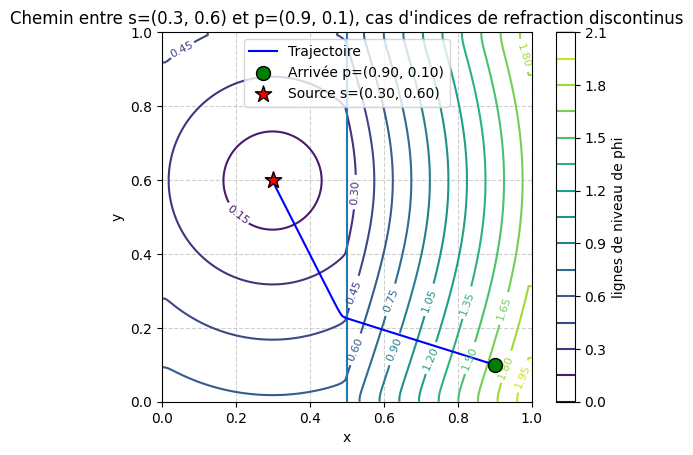

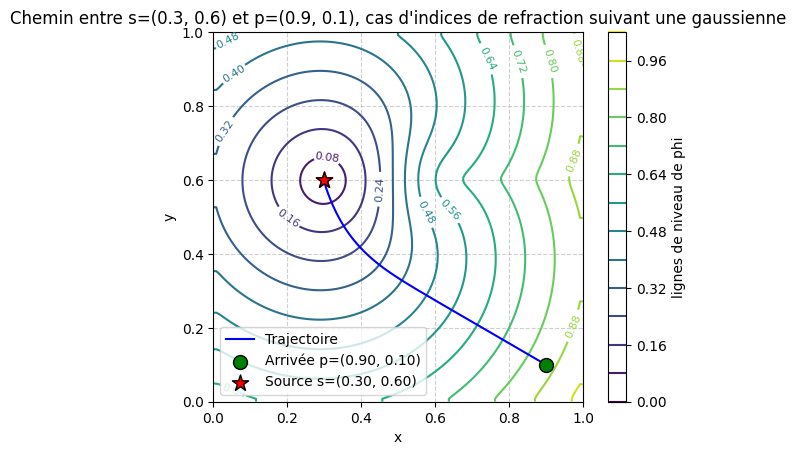

In [ ]:
# plots (Suivant les cas d'indices de refraction définis par N1 ou N2 en amont)
phi_N1 = LF_eikonal(N1, depart, h, dt, TOL=1e-9, N_max=1000)
grad_x_N1, grad_y_N1 = grad_phi(phi_N1, h)
positions_N1 = solve_Euler(mesh_x, mesh_y, p, grad_x_N1, grad_y_N1, N1, N_max, dt)

phi_N2 = LF_eikonal(N2, depart, h, dt, TOL=1e-9, N_max=1000)
grad_x_N2, grad_y_N2 = grad_phi(phi_N2, h)
positions_N2 = solve_Euler(mesh_x, mesh_y, p, grad_x_N2, grad_y_N2, N2, N_max, dt)

_, ax = plt.subplots(1, 1)
plot_contour_lines(s, phi_N1, ax)
plot_path(s, p, positions_N1, ax)
ax.axvline(x=x0, ymin=0, ymax=1)
ax.set_title(f"Chemin entre s=({s[0]}, {s[1]}) et p=({p[0]}, {p[1]}), cas d'indices de refraction discontinus")

_, ax = plt.subplots(1, 1)
plot_contour_lines(s, phi_N2, ax)
plot_path(s, p, positions_N2, ax)
ax.set_title(f"Chemin entre s=({s[0]}, {s[1]}) et p=({p[0]}, {p[1]}), cas d'indices de refraction suivant une gaussienne")

In [ ]:
def solve_Heun(mesh_x, mesh_y, depart, grad_x, grad_y, indice, N_max, dt, tol=1e-6):
    """
    Résoud numériquement l'EDO avec un schéma de Heun
    ----------

    Paramètres :
    -mesh_x, mesh_y : vecteurs des points du maillage en x et en y
    -depart         : point de départ (ou d'arrivée)
    -grad_x          : matrices des composantes suivant x des gradients en les points de la grille
    -grad_y          : matrices des composantes suivant y des gradients en les points de la grille
    -indice         : matrice des indices aux points du maillage
    -N_max          : nombre d'itérations en temps

    Retourne :
    - vecteur des positions X(t^n) à chaque pas de temps
    """

    f = lambda X: - interpole_grad_phi(mesh_x, mesh_y, X, grad_x, grad_y) / (interpole_phi(mesh_x, mesh_y, X, indice)**2)

    positions = np.zeros((N_max, 2), dtype=np.float32)
    positions[0] = depart

    for i in tqdm(range(1,N_max)):
        init_slope = f(positions[i-1])
        X_ = positions[i-1] + init_slope * dt
        med_slope = 0.5 * (init_slope + f(X_))
        new_point = positions[i-1] + med_slope * dt
        if np.linalg.norm(new_point - positions[i-1]) < tol:
            return positions[:i]
        positions[i] = new_point
        positions[i] = positions[i-1] + med_slope * dt

    return positions

 10%|█         | 101/999 [00:00<00:00, 4350.76it/s]


<Axes: title={'center': 'Chemin optimal de p=(0.1, 0.9) à s=(0.3, 0.6)'}, xlabel='x', ylabel='y'>

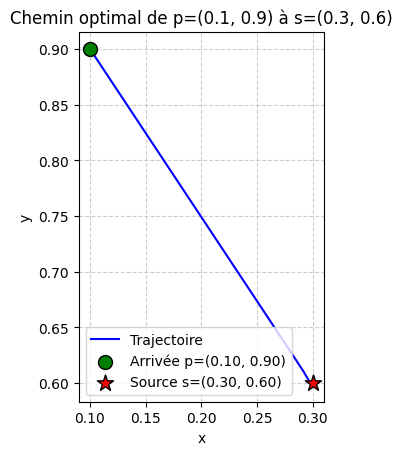

In [ ]:
# proposer un test unitaire
h = 1/128
dt = h/2
n_x = int(1 / h)
s = np.array([0.3, 0.6])
p = np.array([0.1, 0.9])
depart = tuple((s / h).astype(int))
mesh_x = np.linspace(0, 1, n_x)
mesh_y = np.linspace(0, 1, n_x)
N = np.ones((n_x, n_x))
N_max=1000

phi = LF_eikonal(N, depart, h, dt, TOL=1e-9, N_max=1000)
grad_x, grad_y = grad_phi(phi, h)
positions = solve_Heun(mesh_x, mesh_y, p, grad_x, grad_y, N, N_max, dt)

# print(positions)
plot_path(s, p, positions)

In [ ]:
# paramètres de simulation
h = 1/128
dt = h/2
n_x = int(1 / h)
s = np.array([0.3, 0.6])
p = np.array([0.9, 0.1])
depart = tuple((s / h).astype(int))
mesh_x = np.linspace(0, 1, n_x)
mesh_y = np.linspace(0, 1, n_x)
N_max=2000

#N1
x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)
X, Y = np.meshgrid(x, y)
x0 = 0.5
N1 = np.where(Y <= x0, 1, 3)

#N2
sigma = 1.5
l_x, l_y = 0.6, 0.5
N2 = 1 + sigma * np.exp(-50*(X-l_x)**2 - 100*(Y-l_y)**2)

 11%|█         | 218/1999 [00:00<00:00, 4891.97it/s]


Text(0.5, 1.0, "Chemin entre s=(0.3, 0.6) et p=(0.9, 0.1), cas d'indices de refraction suivant une gaussienne")

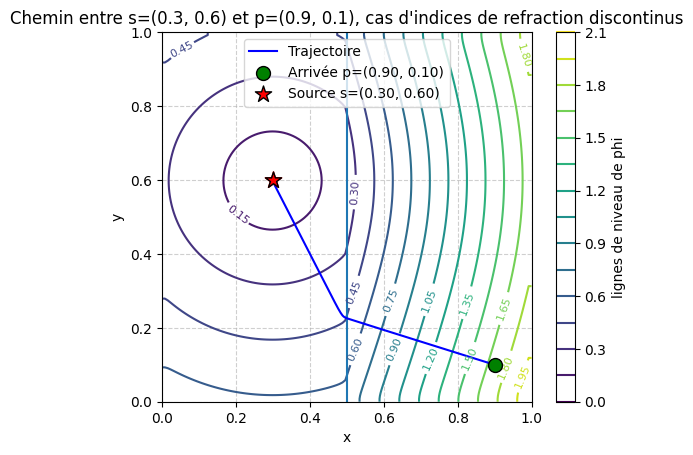

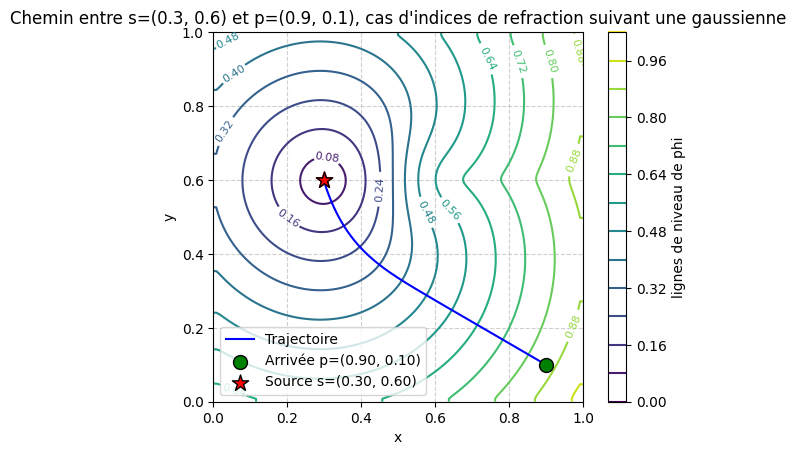

In [ ]:
# plots (Suivant les cas d'indices de refraction définis par N1 ou N2 en amont)
phi_N1 = LF_eikonal(N1, depart, h, dt, TOL=1e-9, N_max=1000)
grad_x_N1, grad_y_N1 = grad_phi(phi_N1, h)
positions_N1 = solve_Heun(mesh_x, mesh_y, p, grad_x_N1, grad_y_N1, N1, N_max, dt)

phi_N2 = LF_eikonal(N2, depart, h, dt, TOL=1e-9, N_max=1000)
grad_x_N2, grad_y_N2 = grad_phi(phi_N2, h)
positions_N2 = solve_Heun(mesh_x, mesh_y, p, grad_x_N2, grad_y_N2, N2, N_max, dt)

_, ax = plt.subplots(1, 1)
plot_contour_lines(s, phi_N1, ax)
plot_path(s, p, positions_N1, ax)
ax.axvline(x=x0, ymin=0, ymax=1)
ax.set_title(f"Chemin entre s=({s[0]}, {s[1]}) et p=({p[0]}, {p[1]}), cas d'indices de refraction discontinus")

_, ax = plt.subplots(1, 1)
plot_contour_lines(s, phi_N2, ax)
plot_path(s, p, positions_N2, ax)
ax.set_title(f"Chemin entre s=({s[0]}, {s[1]}) et p=({p[0]}, {p[1]}), cas d'indices de refraction suivant une gaussienne")

# Pour aller plus loin

Quelques idées pour approfondir et s'entraîner :

## Choix du point de départ

Demander à l'utilisateur de cliquer sur le dessin à l'endroit souhaité pour $X_0$ et l'on récupèrera les coordonnées grâce à la commande *ginput*.

In [ ]:
# !pip install ipympl
!pip install ipywidgets

In [ ]:
!pip install mplcursors

In [ ]:
# paramètres de simulation
h = 1/128
dt = h/2
n_x = int(1 / h)
s = np.array([0.3, 0.6])
depart = tuple((s / h).astype(int))
mesh_x = np.linspace(0, 1, n_x)
mesh_y = np.linspace(0, 1, n_x)
N_max=2000
x0 = 0.5

#N1
x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)
X, Y = np.meshgrid(x, y)
x0 = 0.5
N1 = np.where(Y <= x0, 1, 3)

#N2
sigma = 1.5
l_x, l_y = 0.6, 0.5
N2 = 1 + sigma * np.exp(-50*(X-l_x)**2 - 100*(Y-l_y)**2)

#N
N = N2

 36%|███▌      | 356/1000 [00:00<00:00, 669.63it/s]


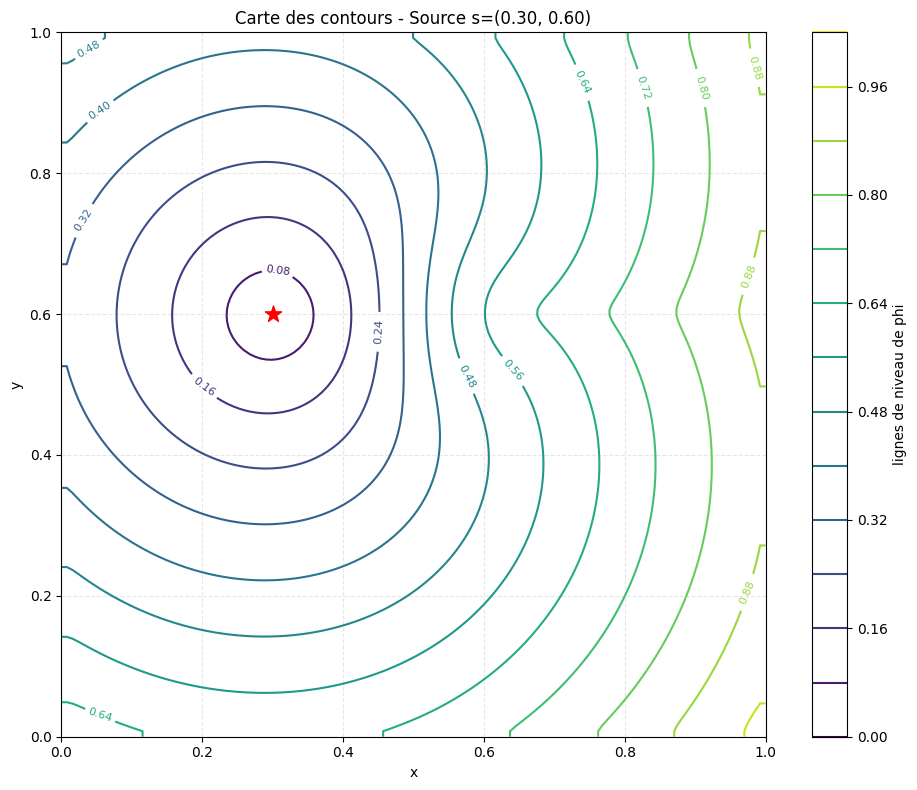

👆 Entrez les coordonnées du point d'arrivée:
⏳ Calcul du chemin en cours pour p=(0.50, 0.50)...


  5%|▍         | 91/1999 [00:00<00:00, 3284.05it/s]


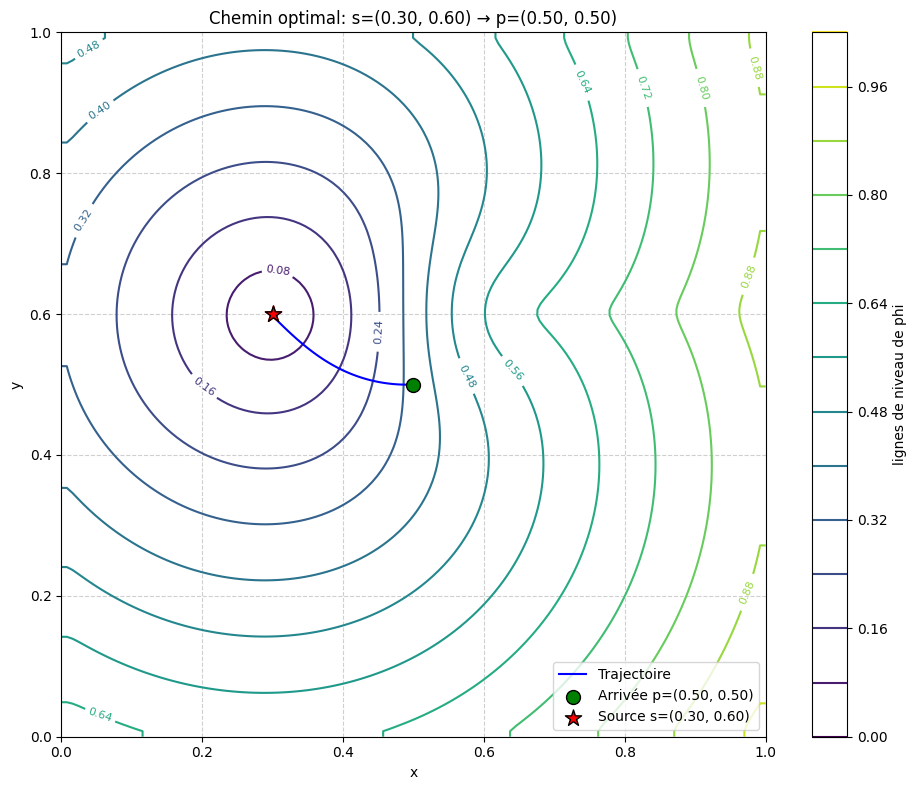

✓ Calcul terminé!


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Préparation des données
h = 1/128
dt = h/2
n_x = int(1 / h)
s = np.array([0.3, 0.6])
depart = tuple((s / h).astype(int))
mesh_x = np.linspace(0, 1, n_x)
mesh_y = np.linspace(0, 1, n_x)
N_max = 2000
N = N2  # ou N1 ou autre selon ce que vous voulez utiliser

phi = LF_eikonal(N, depart, h, dt, TOL=1e-9, N_max=1000)
grad_x, grad_y = grad_phi(phi, h)

# Fonction pour générer un chemin à partir d'un point choisi
def calcul_chemin(point_x, point_y):
    p = np.array([point_x, point_y])
    print(f"⏳ Calcul du chemin en cours pour p=({p[0]:.2f}, {p[1]:.2f})...")

    # Calculer le chemin
    positions = solve_Heun(mesh_x, mesh_y, p, grad_x, grad_y, N, N_max, dt)

    # Afficher le résultat
    fig_final, ax_final = plt.subplots(figsize=(10, 8))
    plot_contour_lines(s, phi, ax_final)
    plot_path(s, p, positions, ax_final)
    ax_final.set_title(f"Chemin optimal: s=({s[0]:.2f}, {s[1]:.2f}) → p=({p[0]:.2f}, {p[1]:.2f})")
    plt.tight_layout()
    plt.show()

    print("✓ Calcul terminé!")
    return positions

# Afficher la carte pour prévisualisation
fig, ax = plt.subplots(figsize=(10, 8))
plot_contour_lines(s, phi, ax)
ax.set_title(f"Carte des contours - Source s=({s[0]:.2f}, {s[1]:.2f})")
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Demander les coordonnées manuellement
print("👆 Entrez les coordonnées du point d'arrivée:")
x_coord = float(input("   x (entre 0 et 1) = "))
y_coord = float(input("   y (entre 0 et 1) = "))

# Calculer et afficher le chemin
positions = calcul_chemin(x_coord, y_coord)

## Obstacles

Des obstacles sont des endroits où l'indice est infini. Mettre un obstacle au milieu du domaine et constater les changements. En particulier, vérifier que les trajectoires évitent les obstacles.

Le programme précédent permet facilement de calculer les temps d'évacuation d'une pièce possédant des obstacles d'une personne située en $(s_x,s_y)$. Les rayons précédemment calculés représenteront la trajectoire qu'elle doit suivre pour évacuer la pièce au plus vite.

In [ ]:
def indice_funct2(x,y,lx,ly):
    # calcul l'indice au point x,y avec les données lx, ly

    center = np.array([0.5, 0.5])
    if center[0] - lx <= x <= center[0] + lx and center[1] - ly <= y <= center[1] + ly:
        return 1e6

    return 1

In [ ]:
# paramètres de simulation
h = 1/128
dt = h/2
n_x = int(1 / h)
n_y = n_x
s = np.array([0.3, 0.6])
p = np.array([0.9, 0.5])
depart = tuple((s / h).astype(int))
mesh_x = np.linspace(0, 1, n_x)
mesh_y = np.linspace(0, 1, n_y)
N_max=2000

# N
lx, ly = 0.1, 0.2
N = np.array([[indice_funct2(h*i, h*j, lx, ly) for j in range(n_y)] for i in range(n_x)])

 10%|▉         | 190/1999 [00:00<00:00, 4799.67it/s]


Text(0.5, 1.0, 'Chemin entre s=(0.3, 0.6) et p=(0.9, 0.5), cas   avec obstacle au mileu')

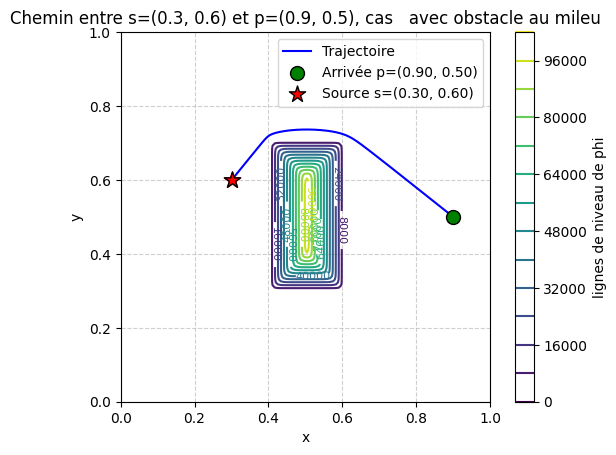

In [ ]:
# plots
phi = LF_eikonal(N, depart, h, dt, TOL=1e-9, N_max=1000)
grad_x, grad_y = grad_phi(phi, h)
positions = solve_Heun(mesh_x, mesh_y, p, grad_x, grad_y, N, N_max, dt)

_, ax = plt.subplots(1, 1)
plot_contour_lines(s, phi, ax)
plot_path(s, p, positions, ax)
ax.set_title(f"Chemin entre s=({s[0]}, {s[1]}) et p=({p[0]}, {p[1]}), cas   avec obstacle au mileu")

## L'île

La fonction suivante vous donne la carte d'indice d'une île. L'île contient des montagnes dans lesquelles on se déplace plus difficilement (l'indice est plus élevé). Elle est entourée d'eau, il y a une rivière qui la traverse et un pont par dessus la rivière.
- Tracer les lignes de niveau de l'indice, ce qui permet d'avoir une carte de l'île.
- Utiliser le programme précédent pour calculer les trajectoires optimales reliant deux points. On demandera à l'utilisateur de cliquer successivement sur le point de départ, ce qui permettra de calculer les lignes de niveau de $\phi$, puis sur le point d'arrivée, ce qui permettra de résoudre l'équation différentielle (1).
- Calculer en particulier les trajectoires optimales pour se rendre d'une plage à l'autre de l'île.

In [ ]:
def indice_ile(x):
    # Renvoie l'indice de l'île
    indice_plage    = 2.
    indice_foret    = 1.
    indice_montagne = 10.
    indice_riviere  = 1.e7
    indice_mer      = 1.e10

    ### centre de l'ile en 0 de rayon 10
    if( (x[0]**2+x[1]**2) > 100.):
        val = indice_mer
    else:
        if( (x[0]**2+x[1]**2) > 81.):
            val = indice_plage
        elif( ((x[0]+2.)**2+(x[1]-1.)**2) > 25):
            val = indice_montagne
        else:
            val = indice_foret

        if(2.*x[0]-x[1] > 1. and 2.*x[0]-x[1] < 2.):
            if(x[0]+2.*x[1] > 1. and x[0]+2.*x[1] < 2.):
                val = indice_foret
            else:
                val = indice_riviere

    return val

In [ ]:
# paramètres de simulation
h = 1/128
dt = h/2
n_x = int(1 / h)
n_y = n_x
s = np.array([0.2, 0.2])
p = np.array([0.6, 0.4])
depart = tuple((s / h).astype(int))
end = tuple((p / h).astype(int))
mesh_x = np.linspace(0, 1, n_x)
mesh_y = np.linspace(0, 1, n_y)
N_max=2000

# N
N = np.array([[indice_ile((x, y)) for y in mesh_y * 20 - 10] for x in mesh_x * 20 - 10])
print("Indice(s) =", N[depart])
print("Indice(p) =", N[end])

Indice(s) = 10.0
Indice(p) = 1.0


  1%|▏         | 25/1999 [00:00<00:00, 4146.04it/s]

[[ 0.56956464  0.48737243]
 [ 0.5678145   0.49172673]
 [ 0.5659091   0.4961783 ]
 [ 0.5638073   0.50071955]
 [ 0.56115305  0.5051983 ]
 [25.791853    0.50905526]]


Text(0.5, 1.0, 'Chemin entre s=(0.2, 0.2) et p=(0.6, 0.4)')

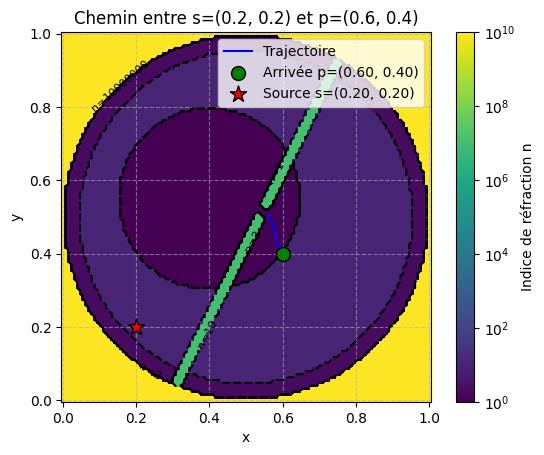

In [ ]:
# plots
phi = LF_eikonal(N, depart, h, dt, TOL=1e-9, N_max=N_max)
grad_x, grad_y = grad_phi(phi, h)
positions = solve_Heun(mesh_x, mesh_y, p, grad_x, grad_y, N, N_max, dt)
print(positions[20:])
positions = positions[:-1]

fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')

# Pour une visualisation en couleur
# On utilisera l'échelle log vu la croissance exponentielle des indices
X, Y = np.meshgrid(mesh_x, mesh_y)
im = ax.pcolormesh(X, Y, N.T, shading='auto', cmap='viridis', norm=colors.LogNorm(vmin=1, vmax=1e10, clip=True))
fig.colorbar(im, ax=ax, label="Indice de réfraction n")
levels = np.array([1., 2., 10., 1.e7, 1.e10])
cs_n = ax.contour(X, Y, N.T, levels=levels, colors='black', linestyles='--')
ax.clabel(cs_n, inline=True, fontsize=8, fmt="n=%.0f")

plot_path(s, p, positions, ax)
# plot_contour_lines(s, phi, ax)
ax.set_title(f"Chemin entre s=({s[0]}, {s[1]}) et p=({p[0]}, {p[1]})")